# Starbucks Capstone Challenge

## Table of Contents
- [Introduction](#intro)
- [Data Gathering](#gather)
- [Data Exploration](#explore)
- [Data Wrangling and Tidying](#tidy)
- [Visualisation](#viz)
- [Conclusion](#conclude)


<a id='intro'></a>
### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

<a id='gather'></a>
# Data Gathering

In [1]:
# Import the necessary libraries
import pandas as pd
import numpy as np
import math
import json

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

# read in the json files
portfolio = pd.read_json('portfolio.json', orient='records', lines=True)
profile = pd.read_json('profile.json', orient='records', lines=True)
transcript = pd.read_json('transcript.json', orient='records', lines=True)

<a id='explore'></a>
# Data Exploration

In [2]:
# Print first five rows
portfolio.head()

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7


In [3]:
# Check portfolio info
portfolio.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   reward      10 non-null     int64 
 1   channels    10 non-null     object
 2   difficulty  10 non-null     int64 
 3   duration    10 non-null     int64 
 4   offer_type  10 non-null     object
 5   id          10 non-null     object
dtypes: int64(3), object(3)
memory usage: 608.0+ bytes


In [4]:
# Check the dtype of values in channels
type(portfolio.channels[0])

list

In [5]:
# Print profile's first five rows
profile.head()

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN


In [6]:
# Print profile information
profile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            14825 non-null  object 
 1   age               17000 non-null  int64  
 2   id                17000 non-null  object 
 3   became_member_on  17000 non-null  int64  
 4   income            14825 non-null  float64
dtypes: float64(1), int64(2), object(2)
memory usage: 664.2+ KB


In [7]:
# Print first five rows
transcript.head()

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


In [8]:
transcript.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   person  306534 non-null  object
 1   event   306534 non-null  object
 2   value   306534 non-null  object
 3   time    306534 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 9.4+ MB


## Data Quality Issues and a Possible Fix

1. `channels` column should be object instead of list. This can be done by converting the entire column to string

2. column names should be very informative. This can be done by including appropriate units to the column names

3. `gender`, `offer_type` and `event` columns should be categorical. This can be done by calling pandas' `Categorical` method on the columns

4. `became_member_on` should be datetime, not int. This can be done using pandas's `datetime` method

5. `value` column contains dictionary. A pattern should be followed to split it to form new columns

<a id='tidy'></a>
# Data Wrangling and Tidying

In [9]:
def clean_portfolio(df = portfolio):
    '''
    Wrangle and clean portfolio dataframe.
    
    Input: portfolio dataframe
    
    Output: Return new_portfolio dataframe
    '''
    
    new_portfolio = portfolio.copy()
    
    # Rename columns
    new_portfolio.rename(columns={'id': 'offer_id', 'difficulty': 'difficulty($)', \
                                  'duration': 'duration(days)'}, inplace=True)
    
    # Convert channels column to str
    new_portfolio.channels = new_portfolio.channels.astype(str)
    
    # Convert column to float
    new_portfolio.reward = new_portfolio.reward.astype(float)
    
    # Convert offer_type column to categorical
    new_portfolio.offer_type = pd.Categorical(new_portfolio.offer_type)
    return new_portfolio

In [10]:
new_portfolio = clean_portfolio()

In [11]:
# Confirm new_portfolio dataframe
new_portfolio.head()

,reward,channels,difficulty($),duration(days),offer_type,offer_id
0,10.0,"['email', 'mobile', 'social']",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10.0,"['web', 'email', 'mobile', 'social']",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0.0,"['web', 'email', 'mobile']",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5.0,"['web', 'email', 'mobile']",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5.0,"['web', 'email']",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7


In [12]:
new_portfolio.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   reward          10 non-null     float64 
 1   channels        10 non-null     object  
 2   difficulty($)   10 non-null     int64   
 3   duration(days)  10 non-null     int64   
 4   offer_type      10 non-null     category
 5   offer_id        10 non-null     object  
dtypes: category(1), float64(1), int64(2), object(2)
memory usage: 670.0+ bytes


In [13]:
def clean_transcript(df = transcript):
    '''
    Wrangle and clean transcript dataframe.
    
    Input: portfolio dataframe
    
    Output: Return new_transcript dataframe
    '''
    
    # Get a copy of transcript   
    new_transcript = df.copy()
    
    # Rename columns
    new_transcript.rename(columns={'person': 'customer_id', 'time': 'time(hours)'}, inplace=True)
    
    # Use pattern from value column to split it into multiple columns
    # Extract desired values and attach them to df
    new_transcript['offer_id_sent'] = new_transcript.value.astype(str).str.lstrip('{')\
    .str.rstrip('}').str.split('(,|:)', expand=True).get(2)
    
    # Strip preceding white space and quotation mark
    new_transcript.offer_id_sent = new_transcript.offer_id_sent.str.lstrip(" ").str.replace("'", "")
    
    # Split value column, get desired values, and attach new columns to df
    new_transcript['reward'] = new_transcript.value.astype(str).str.lstrip('{')\
    .str.rstrip('}').str.split('(,|:)', expand=True).get(6)
    
    # Create a new column
    new_transcript['no_offer_transaction_amount($)'] = new_transcript.offer_id_sent[transcript.event == 'transaction']

    # Convert columns to float
    new_transcript[['reward', 'no_offer_transaction_amount($)']] = new_transcript\
    [['reward', 'no_offer_transaction_amount($)']].astype(float)

    # new_transcript.offer_id[new_transcript.event == 'transaction'].
    new_transcript.offer_id_sent.loc[transcript.event == 'transaction'] = np.nan

    # Drop unwanted column
    new_transcript.drop('value', axis=1, inplace=True)
    
    # Convert event colum to categorical
    new_transcript.event = pd.Categorical(new_transcript.event)
    
    # Replace None with NaN
#     new_transcript.offer_id_sent.replace({None: np.nan}, inplace=True)
#     new_transcript.reward.replace({None: np.nan}, inplace=True)
    
    return new_transcript

In [14]:
new_transcript = clean_transcript()

C:\Users\MR. NSIKAN\AppData\Local\Temp\ipykernel_9060\1673537150.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_transcript.offer_id_sent.loc[transcript.event == 'transaction'] = np.nan


In [15]:
# Confirm new_transcript dataframe
new_transcript.head()

,customer_id,event,time(hours),offer_id_sent,reward,no_offer_transaction_amount($)
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,NaN
1,a03223e636434f42ac4c3df47e8bac43,offer received,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,NaN
2,e2127556f4f64592b11af22de27a7932,offer received,0,2906b810c7d4411798c6938adc9daaa5,NaN,NaN
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,0,fafdcd668e3743c1bb461111dcafc2a4,NaN,NaN
4,68617ca6246f4fbc85e91a2a49552598,offer received,0,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,NaN


In [16]:
new_transcript.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 6 columns):
 #   Column                          Non-Null Count   Dtype   
---  ------                          --------------   -----   
 0   customer_id                     306534 non-null  object  
 1   event                           306534 non-null  category
 2   time(hours)                     306534 non-null  int64   
 3   offer_id_sent                   167581 non-null  object  
 4   reward                          33579 non-null   float64 
 5   no_offer_transaction_amount($)  138953 non-null  float64 
dtypes: category(1), float64(2), int64(1), object(2)
memory usage: 12.0+ MB


In [17]:
def clean_profile(df = profile):
    
    '''
    Wrangle and clean profile dataframe.
    
    Input: profile dataframe
    
    Output: Return new_profile dataframe
    '''
    
    new_profile = df.copy()
    # Rename columns
    new_profile.rename(columns={'id': 'customer_id', 'income': 'income($)'}, inplace=True)
    
    # Convert became_member_on to Datetime
    new_profile.became_member_on = pd.to_datetime(new_profile.became_member_on, format='%Y%m%d')
    # Replace None with NaN
    new_profile.gender.replace({None: np.nan}, inplace=True)
    
    # Convert gender colum to categorical
    new_profile.gender = pd.Categorical(new_profile.gender)
    
    return new_profile

In [18]:
new_profile = clean_profile()

In [19]:
# Confirm new_profile
new_profile.head()

,gender,age,customer_id,became_member_on,income($)
0,NaN,118,68be06ca386d4c31939f3a4f0e3dd783,2017-02-12,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000.0
2,NaN,118,38fe809add3b4fcf9315a9694bb96ff5,2018-07-12,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,2017-05-09,100000.0
4,NaN,118,a03223e636434f42ac4c3df47e8bac43,2017-08-04,NaN


In [20]:
new_profile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   gender            14825 non-null  category      
 1   age               17000 non-null  int64         
 2   customer_id       17000 non-null  object        
 3   became_member_on  17000 non-null  datetime64[ns]
 4   income($)         14825 non-null  float64       
dtypes: category(1), datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 548.1+ KB


In [21]:
# Merge datasets
def merge_dfs(df1, df2, df3,col1, col2, col3, col4):
    '''
    Merge three dataframes together.
    
    Input: Three dataframes and four columns:
    df1: new_transcript, df2: new_profile, df3: new_portfolio
    col1: customer_id, col2: customer_id, col3: offer_id_sent, col4: offer_id
    
    Output: Return merged_df dataframe
    '''
    new_df = df1.merge(df2, left_on = col1, right_on = col2, how = 'outer')
    new_df = new_df.merge(df3, left_on = col3, right_on = col4, how = 'outer')
    
    # Rename column
    new_df.rename(columns={'reward_x': 'reward'}, inplace=True)
    # Drop unwanted column
    new_df.drop(['reward_y','offer_id'],axis=1, inplace=True)
    return new_df

merged_df = merge_dfs(new_transcript, new_profile, new_portfolio, 'customer_id',\
                      'customer_id', 'offer_id_sent', 'offer_id')

In [22]:
# Get the first five rows of merged_df
merged_df.head()

,customer_id,event,time(hours),offer_id_sent,reward,no_offer_transaction_amount($),gender,age,became_member_on,income($),channels,difficulty($),duration(days),offer_type
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,NaN,F,75,2017-05-09,100000.0,"['web', 'email', 'mobile']",5.0,7.0,bogo
1,78afa995795e4d85b5d9ceeca43f5fef,offer viewed,6,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,NaN,F,75,2017-05-09,100000.0,"['web', 'email', 'mobile']",5.0,7.0,bogo
2,78afa995795e4d85b5d9ceeca43f5fef,offer completed,132,9b98b8c7a33c4b65b9aebfe6a799e6d9,5.0,NaN,F,75,2017-05-09,100000.0,"['web', 'email', 'mobile']",5.0,7.0,bogo
3,e2127556f4f64592b11af22de27a7932,offer received,408,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,NaN,M,68,2018-04-26,70000.0,"['web', 'email', 'mobile']",5.0,7.0,bogo
4,e2127556f4f64592b11af22de27a7932,offer viewed,420,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,NaN,M,68,2018-04-26,70000.0,"['web', 'email', 'mobile']",5.0,7.0,bogo


In [23]:
# Get a new dataframe without duplicated rows
df = merged_df[~(merged_df.duplicated())]
df.head()

,customer_id,event,time(hours),offer_id_sent,reward,no_offer_transaction_amount($),gender,age,became_member_on,income($),channels,difficulty($),duration(days),offer_type
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,NaN,F,75,2017-05-09,100000.0,"['web', 'email', 'mobile']",5.0,7.0,bogo
1,78afa995795e4d85b5d9ceeca43f5fef,offer viewed,6,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,NaN,F,75,2017-05-09,100000.0,"['web', 'email', 'mobile']",5.0,7.0,bogo
2,78afa995795e4d85b5d9ceeca43f5fef,offer completed,132,9b98b8c7a33c4b65b9aebfe6a799e6d9,5.0,NaN,F,75,2017-05-09,100000.0,"['web', 'email', 'mobile']",5.0,7.0,bogo
3,e2127556f4f64592b11af22de27a7932,offer received,408,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,NaN,M,68,2018-04-26,70000.0,"['web', 'email', 'mobile']",5.0,7.0,bogo
4,e2127556f4f64592b11af22de27a7932,offer viewed,420,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,NaN,M,68,2018-04-26,70000.0,"['web', 'email', 'mobile']",5.0,7.0,bogo


In [24]:
# Check if there's any other duplicated row
df.duplicated().sum()

0

In [25]:
# Basic statistics of merged_df
merged_df.describe()

,time(hours),reward,no_offer_transaction_amount($),age,income($),difficulty($),duration(days)
count,306534.000000,33579.000000,138953.000000,306534.000000,272762.000000,167581.000000,167581.000000
mean,366.382940,4.904137,12.777356,60.909367,64337.000755,7.850401,6.610737
std,200.326314,2.886647,30.250529,26.032030,21243.762941,5.048944,2.136130
min,0.000000,2.000000,0.050000,18.000000,30000.000000,0.000000,3.000000
25%,186.000000,2.000000,2.780000,43.000000,48000.000000,5.000000,5.000000
50%,408.000000,5.000000,8.890000,57.000000,62000.000000,10.000000,7.000000
75%,528.000000,5.000000,18.070000,72.000000,78000.000000,10.000000,7.000000
max,714.000000,10.000000,1062.280000,118.000000,120000.000000,20.000000,10.000000


In [26]:
# Check df information
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 306137 entries, 0 to 306533
Data columns (total 14 columns):
 #   Column                          Non-Null Count   Dtype         
---  ------                          --------------   -----         
 0   customer_id                     306137 non-null  object        
 1   event                           306137 non-null  category      
 2   time(hours)                     306137 non-null  int64         
 3   offer_id_sent                   167184 non-null  object        
 4   reward                          33182 non-null   float64       
 5   no_offer_transaction_amount($)  138953 non-null  float64       
 6   gender                          272388 non-null  category      
 7   age                             306137 non-null  int64         
 8   became_member_on                306137 non-null  datetime64[ns]
 9   income($)                       272388 non-null  float64       
 10  channels                        167184 non-null  object 

<a id='viz'></a>
# Data Visualisation

## What is the population of customers based on gender?

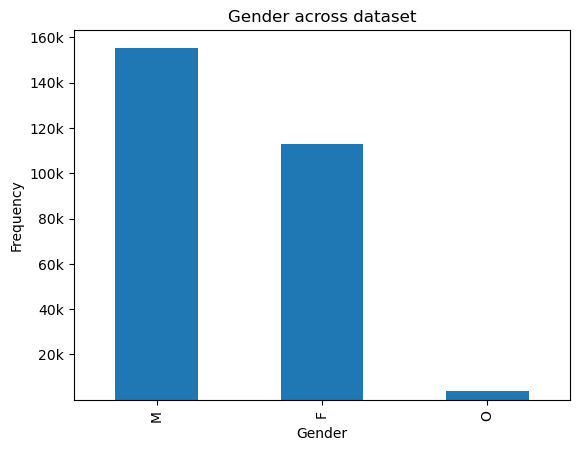

In [27]:
def pop_gender_bar():
    df.gender.value_counts().plot(kind = 'bar');
    y_ticks = np.arange(20000,160001, 20000)
    y_label = ['20k', '40k', '60k', '80k', '100k', '120k', '140k', '160k']
    plt.yticks(y_ticks, y_label);
    plt.xlabel('Gender');
    plt.ylabel('Frequency');
    plt.title('Gender across dataset');
    plt.savefig('pop_gender_bar.png');
pop_gender_bar()

In the bar graph above, we can see the distribution of customer gender across the dataset. 
I used the pandas' value_counts method to aggregate the total number of each gender across the dataset. 
We have about 160k male customers, about 120k female customers, and about 4k undisclosed gender.

## What is the distribution of customers in terms of event?

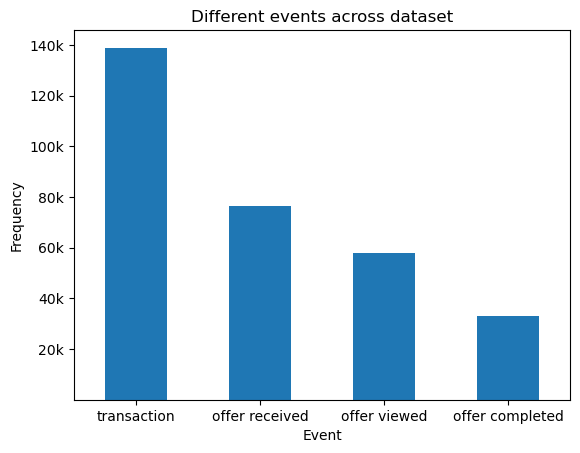

In [28]:
def event_bar():
    df.event.value_counts().plot(kind = 'bar');
    y_ticks = np.arange(20000,140001,20000)
    y_label = ['20k', '40k', '60k', '80k', '100k', '120k', '140k']
    plt.xticks(rotation=0);
    plt.yticks(y_ticks, y_label);
    plt.xlabel('Event');
    plt.ylabel('Frequency');
    plt.title('Different events across dataset');
    plt.savefig('event_bar.png');
event_bar()

In the bar graph above, we can see the distribution of customers based on events. event column includes: transaction, offer received, offer viewed, and offer completed. I used the pandas' value_counts method to aggregate the total number of customers in each event category. We have about 140k customers in the transaction category, about 80k customers received offers, about 60k customers viewed the offer, and about 40k customers completed the offer.

## What are the different offers and how are they distributed?

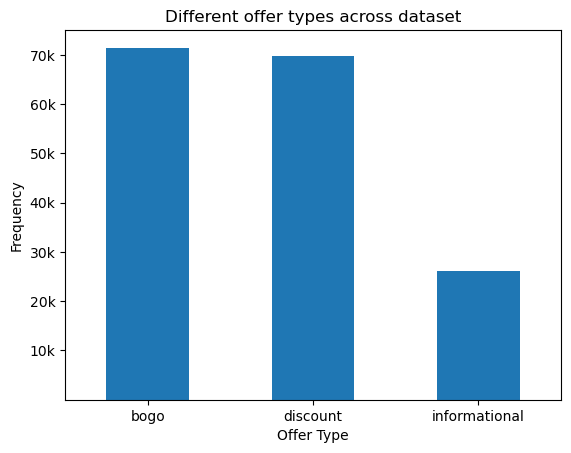

In [29]:
def offer_type_bar():
    
    df.offer_type.value_counts().plot(kind = 'bar');
    y_ticks = np.arange(10000,70001,10000)
    y_label = ['10k', '20k', '30k', '40k', '50k', '60k', '70k']
    plt.xticks(rotation=0);
    plt.yticks(y_ticks, y_label);
    plt.xlabel('Offer Type');
    plt.ylabel('Frequency');
    plt.title('Different offer types across dataset');
    plt.savefig('offer_type_bar.png');
offer_type_bar()

In the bar graph above, we can see the distribution of customers based on offer types. `offer_type` column includes: BOGO, discount, and informational.
 Again, I used the value_counts method to aggregate the total number of customers in each offer type category. 
BOGO and discount offers are almost distributed evenly with about 70k customers receiving each offer. 
Informational offer is the least distributed with about 30k customers receiving it.

## Which offer type is preferable based on gender?

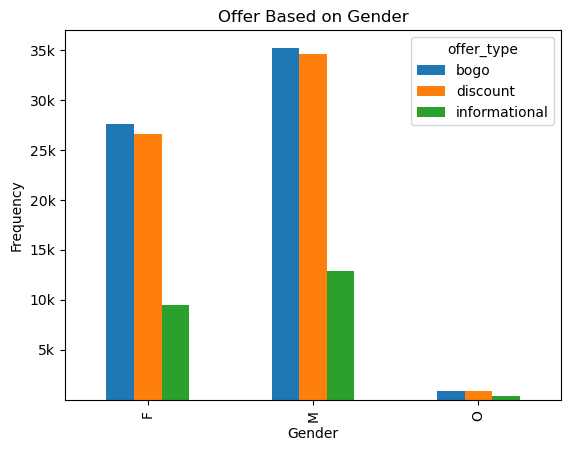

In [30]:
def gender_offer_bar():
    
    pd.crosstab(index=df.gender, columns=df.offer_type).plot(kind = 'bar');

    y_ticks = np.arange(5000,35001,5000)
    y_label = ['5k', '10k', '15k', '20k', '25k', '30k', '35k']
    plt.yticks(y_ticks, y_label);
    plt.xlabel('Gender');
    plt.ylabel('Frequency');
    plt.title('Offer Based on Gender');
    plt.savefig('gender_offer_bar.png');
gender_offer_bar()

The clustered bar graph above shows the relationship between offer type and gender. Firstly, I used Pandas' crosstab function to relate the two columns, with gender as the index and offer type as the columns. There are three offer types in the dataset: BOGO, discount, and informational. There are three categories in the gender column: Female(F), Male(M), and Other(O).
From the graph:
1. About 27k F customers received BOGO offers, 26k received a discount offer, and about 9k received an informational offer.
2. About 35k customers received a BOGO offers, a little below 35k received a discount offer, and about 13k received an informational offer.
3. Other categories received significantly fewer offers.

## How do offer types relate to events?

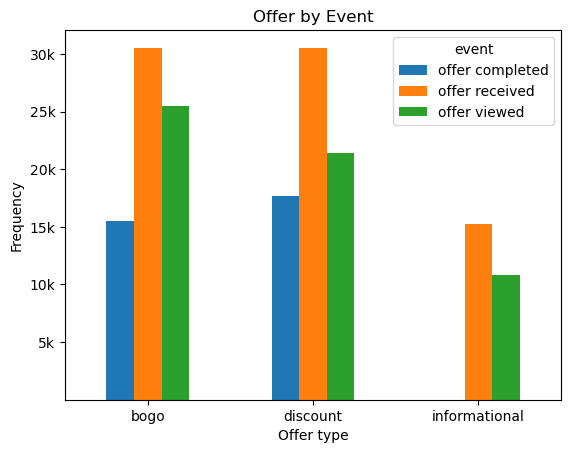

In [31]:
def offer_event_bar():
    pd.crosstab(index=df.offer_type, columns=df.event).plot(kind = 'bar');
    y_ticks = np.arange(5000,30001, 5000)
    y_label = ['5k', '10k', '15k', '20k', '25k', '30k']
    plt.xticks(rotation=0);
    plt.yticks(y_ticks, y_label);
    plt.xlabel('Offer type');
    plt.ylabel('Frequency');
    plt.title('Offer by Event');
    plt.savefig('offer_event_bar.png');
offer_event_bar()

The clustered bar graph above shows the relationship between offer type  and event. Again, I used Pandas' crosstab function to relate the two columns, with an event as the index and offer_type as the columns. 
There are three offer types in the dataset: BOGO, discount, and informational.
 There are four categories in the event  column: offer_received, offer viewed, offer_completed, and transaction. This graph displays offer type by event relationship across the dataset. 
As can be seen, three categories are displayed: offer_received, offer viewed and offer completed. The transaction category is absent because those who belong there did not receive any offer.

1. From the graph, about 30k customers received the BOGO offer, 25k viewed it, and a little over 15k completed the offer.
2. About 30k customers received a discount offer, about 21k viewed it, and about 18k completed the offer.
3. A little over 15k customers received an informational offer, about 10k viewed it, and none completed the offer.

## Why do customers complete BOGO and discount offers but not informational offer?

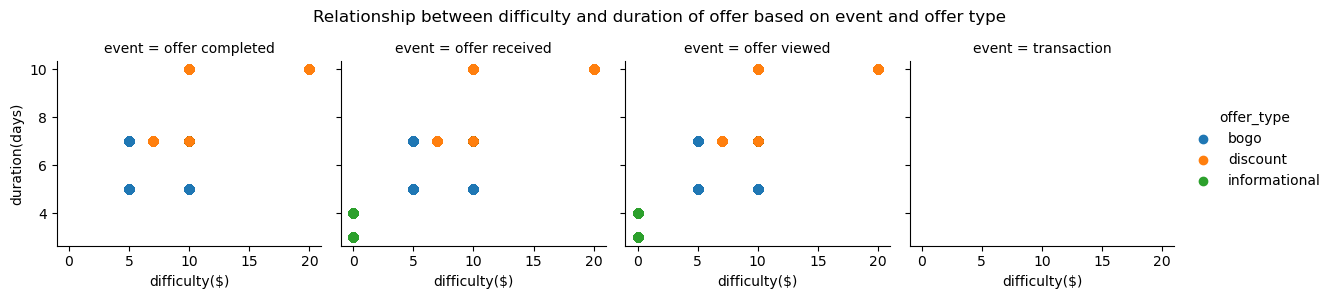

In [32]:
def diff_duration_plot():
    # Get a subset data without transaction rows
    off_df = df[df.event!= 'transaction']
    plotted = sns.FacetGrid(data=off_df, col= 'event', hue = 'offer_type');
    plotted.map(plt.scatter, 'difficulty($)', 'duration(days)');
    plotted.fig.suptitle('Relationship between difficulty and duration of offer based on event and offer type');
    plotted.fig.subplots_adjust(top=.81) # adjust the Figure
    plotted.add_legend();
    plt.savefig('diff_duration_plot.png');
diff_duration_plot()

Above are scatter plots that show the relationship between offer type, events, duration of the offer, and difficulty (amount of money) needed to complete the offer.

1. Duration of BOGO offer is between 5 to 7 days, difficulty to complete the offer is between 5 to 10 dollars
2. Duration of the discount offer is between 7 to 10 days, difficulty to complete the offer is between 6 to 20 dollars.
3. Duration of an informational offer is between 1 to 4 days, difficulty to complete the offer is $0. Maybe this offer is not lucrative enough or time is too short to complete it.

## What specific income group of customers receives offers?

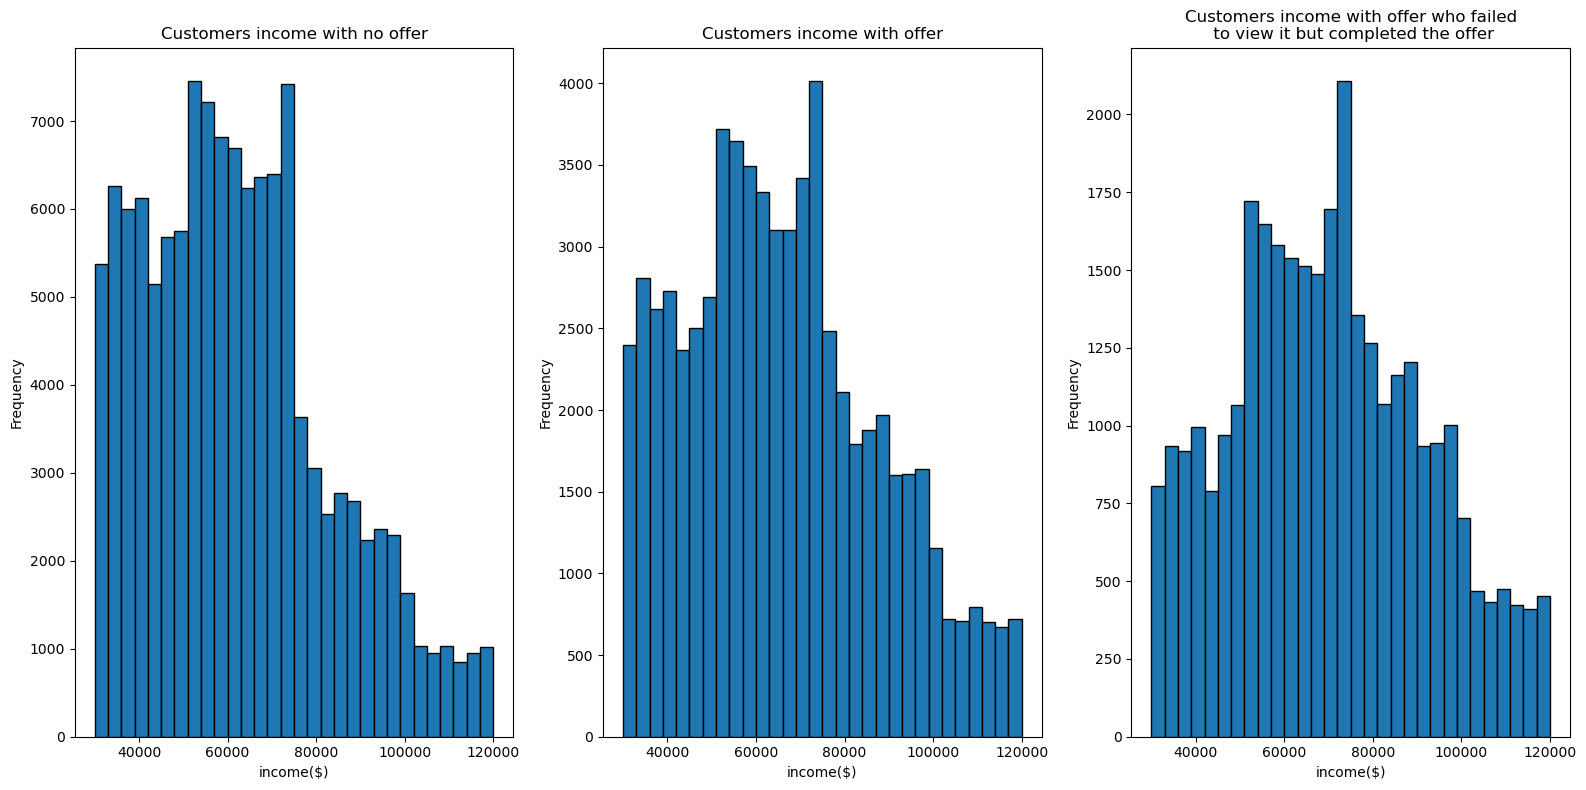

In [33]:
# Get the subset of data required for this plot
transaction = df[df.event == 'transaction']
offer_received = df[df.event == 'offer received']
not_viewed_offer = df[df.event != 'offer viewed']

def income_group_hist():
    plt.figure(figsize=[16, 8]);
    bins = np.arange(transaction['income($)'].min(), transaction['income($)'].max()+1, 3000)

    plt.subplot(131);
    plt.hist(transaction['income($)'], bins= bins, edgecolor = 'black');
    plt.xlabel('income($)');
    plt.ylabel('Frequency');
    plt.title('Customers income with no offer');

    plt.subplot(132);
    plt.hist(offer_received['income($)'], bins= bins, edgecolor = 'black');

    plt.xlabel('income($)');
    plt.ylabel('Frequency');
    plt.title('Customers income with offer');

    plt.subplot(133);
    plt.hist(not_viewed_offer['income($)'][not_viewed_offer.event =='offer completed'], bins= bins, edgecolor = 'black');
    plt.xlabel('income($)');
    plt.ylabel('Frequency');
    plt.title('Customers income with offer who failed\n to view it but completed the offer');
    plt.tight_layout()
    plt.savefig('income_group_hist.png');
income_group_hist()

The histograms above show the distributions of customers' income with an offer, no offer, and those with offers but never read. I segmented the event column into subsets to get the listed categories.
As can be seen, the three graphs look similar. This indicates that offers are not sent to any specific group of customers based on income.

## Do the ages of customers determine offers?

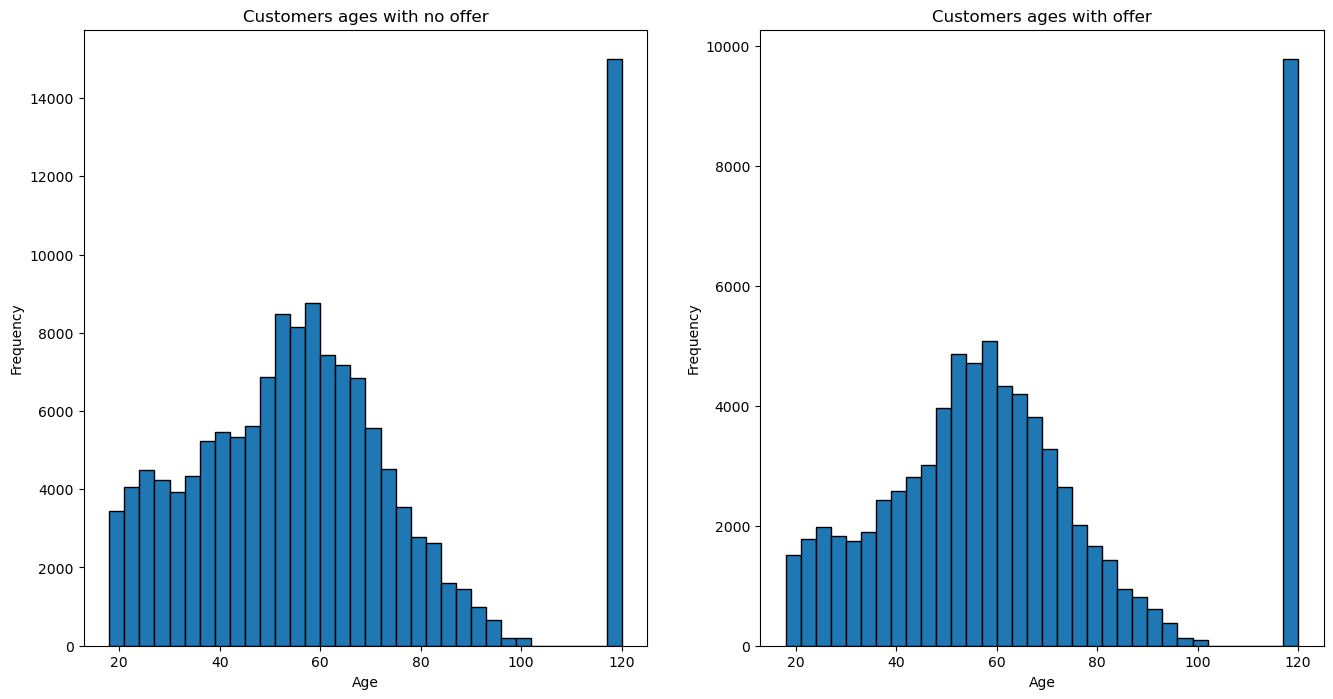

In [34]:
def age_hist():
    plt.figure(figsize=[16, 8]);
    bins = np.arange(transaction['age'].min(), transaction['age'].max()+3, 3)

    plt.subplot(121);
    plt.hist(transaction['age'], bins= bins, edgecolor = 'black');
    plt.xlabel('Age');
    plt.ylabel('Frequency');
    plt.title('Customers ages with no offer');

    plt.subplot(122);
    plt.hist(offer_received['age'], bins= bins, edgecolor = 'black');

    plt.xlabel('Age');
    plt.ylabel('Frequency');
    plt.title('Customers ages with offer');
    plt.savefig('age_hist.png');
age_hist()

The histograms above show the distribution of customers' ages with and without offers. 
The left histogram is for customers with no offers, and the right is for customers with offers. Both graphs look similar and somewhat normally distributed.
1. Mean age is about 55 years
2. The graphs are right-skewed with an outstanding outlier. It entails that any age above 100 does not belong.
3. It seems age does not influence the offer.

## Are offers sent to only new or existing customers or both?

<Figure size 1600x800 with 0 Axes>

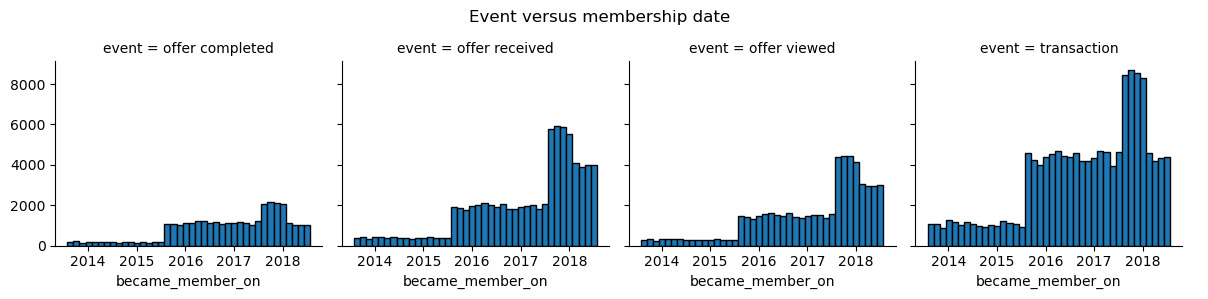

In [35]:
def event_date_hist():
    plt.figure(figsize=[16,8])
    plotted = sns.FacetGrid(data=df, col= 'event');
    plotted.map(plt.hist, 'became_member_on', bins = 40, edgecolor = 'black');
    plotted.fig.suptitle('Event versus membership date');
    plotted.fig.subplots_adjust(top=.81) # adjust the Figure
    plotted.add_legend();
    plt.savefig('event_date_hist.png');
event_date_hist()

#### Finding:
Offers are sent to a sample of existing and new customers.

## How are the numerical columns related?

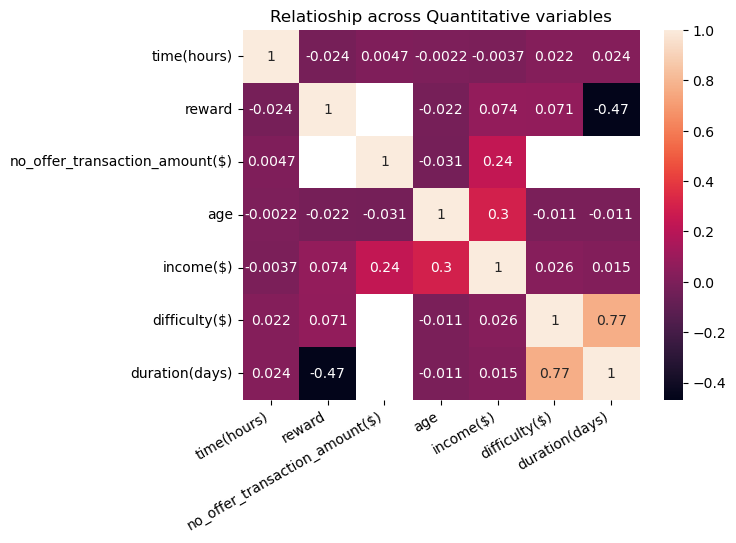

In [37]:
def corr_heatmap():
    
    sns.heatmap(df.corr(), annot=True, );
    plt.xticks(rotation=30, ha='right');
    plt.title('Relatioship across Quantitative variables')
corr_heatmap()

Above is a heatmap that displays a fine graph. I used Pandas' `corr` funtion to get the linear relationships between quantitative variables. This heatmap comprises of little squares with values. The values display the level of relationship between two variables. 0 means no linear relationship, 1 means strong positive linear relationship, and -1 means strong negative linear relationship. To the right of this graph is a colour bar that displays the level of relationship. You can see the diagonal from left to right with value 1. This is the relationship between a value and itself. From the graph, most of the variables do not have any linear relationship. `difficulty($)` and `duration(days)` have a strong positive relationship with a value of 0.77, while `reward` and `duration(days)` have a weak negative relationship with the value -0.47

<a id='conclude'></a>
# Conclusion

After a thorough analysis of the Starbucks dataset to understand the patterns of offer distribution and customers' behaviours and responses, the following points were garnered:
1. Offers are sent to a sample of customers across the dataset.
2. Out of the three types of offer; BOGO was the most sent offer, closely followed by the discount offer. The least sent was the informational offer.
3. While BOGO and discount offers were completed by some customers, no customer completed the informational offer. This may be because the time to complete this offer was too short when compared to other offers.
4. It does not look like offers had a huge influence on customers. This is because the trend of customers who completed an offer and that of those who completed a transaction without an offer look similar. 
It is understood that an offer is meant to woo a customer to make more transactions. This does not look like the case here. Maybe more customers need to receive offers for us to investigate whether or not it influences customers.